# Cohort Analysis

## Introduction

More often than not, i've been asked "Hey Ian, i would like know how good are our new customers, are they spending as much money on our product as we'd originally thought they would?" or in the case of telco industry, "How often are our roamers travelling?". There are probably a number of thoughts going through your head right now as to ways in which you should or can slice and dice data to have a clearer picture. I found this course about [*Customer Segmentation in Python*](https://www.datacamp.com/courses/customer-segmentation-in-python) by Karolis Urbonas on Data camp that i think is really useful for the future. It uses a dataset from UCI Machine Learning Repository. Depending on what questions you are trying to answer, you can use this as a guiding framework.

#### 1. Loading data sets and packages

In [27]:
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
dateCols = ['InvoiceDate']
online = pd.read_csv('online.csv', parse_dates = dateCols) 

# Double checking the date column is loaded as dates
online.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70864 entries, 0 to 70863
Data columns (total 9 columns):
Unnamed: 0     70864 non-null int64
InvoiceNo      70864 non-null int64
StockCode      70864 non-null object
Description    70864 non-null object
Quantity       70864 non-null int64
InvoiceDate    70864 non-null datetime64[ns]
UnitPrice      70864 non-null float64
CustomerID     70864 non-null int64
Country        70864 non-null object
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 4.9+ MB


#### 2. Data wrangling

In [30]:
# this function is to get the first day of the month
def get_month(x):
    return dt.date(x.year, x.month,1)

# after getting the month from invoice date, i convert it to datetime format
online['InvoiceMonth'] = pd.to_datetime(online['InvoiceDate'].apply(get_month))

# checking the format the invoicemonth
#online.info()

In [31]:
# Need to group by customer id and invoice month in order to work out when was the first purchase day as we 
#define that as the start of the cohort
grouping = online.groupby('CustomerID')['InvoiceMonth']

# to get the first transaction month
online['CohortMonth'] = grouping.transform('min')

# customer 14286's first purchase was made on 2011-04-11, lets filter for the customer and have a look at their transaction 
# just a sanity check
#online.loc[online['CustomerID'] == 14286].sort_values('InvoiceDate')


In [32]:
# define a function to extract the individual year, month and day integer values
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.month
    return year, month, day

# getting the respective year and month, days can be ignored as we are not using it
invoice_year, invoice_month, invoice_day = get_date_int(online, 'InvoiceMonth')
cohort_year, cohort_month, cohort_day = get_date_int(online, 'CohortMonth')

# to work out the difference in time between the first transaction made and the current transaction
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
days_diff = invoice_day - cohort_day


#### 3. Getting cohorts

In [34]:
# Extract the difference in months from all previous values
online['CohortIndex'] = years_diff*12 + months_diff + 1
online.head(n=3)

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-01,2011-04-01,7
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-01,2011-09-01,3
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07-01,2011-07-01,1


In [40]:
#in order to see retention, we need to group by cohort
grouping = online.groupby(['CohortMonth','CohortIndex'])

# Depending on what metric you are after, you should group by different things ie customer id for counting unique or average price per product
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique) #its in series format after grouping, hence need to reset index
cohort_data = cohort_data.reset_index()
cohort_data['CohortMonth'] = cohort_data['CohortMonth'].dt.date # i had to do this get rid of the time on the datetime
#cohort_data.info() # back in dataframe format
cohort_counts = cohort_data.pivot(index = 'CohortMonth',
                                  columns = 'CohortIndex',
                                  values = 'CustomerID')


In [42]:
# store first column as cohort sizes because we need to divide the rest of the columnds by the first column
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis = 0)

# Converting the values into percentage
#retention.info()

#### 4.Visualizing Cohorts

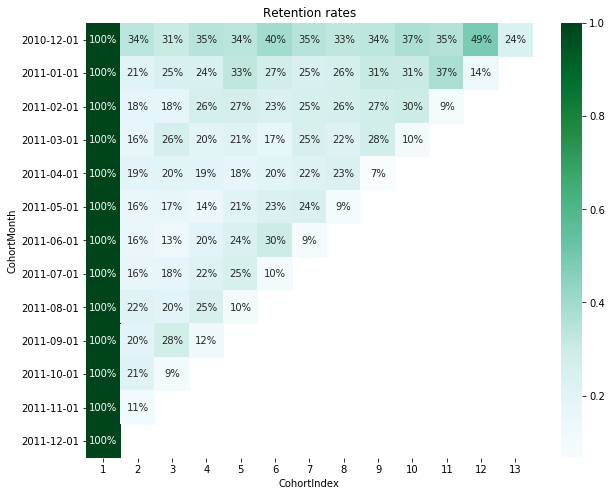

In [43]:
plt.figure(figsize=(10,8))
sns.heatmap(data = retention,
           annot=True,
           fmt = '.0%',
           cmap = 'BuGn')
plt.title('Retention rates')
plt.show()